<a href="https://colab.research.google.com/github/liao961120/cilin/blob/main/etc/naive_bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
!pip install -q CompoTree
!pip install -q cilin
!pip install -q opencc

In [50]:
# Download font data
!wget 'https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKtc-hinted.zip'
!mkdir /tmp/fonts
!unzip -qo NotoSansCJKtc-hinted.zip -d /tmp/fonts/
!mv /tmp/fonts/NotoSansMonoCJKtc-Regular.otf /usr/share/fonts/truetype/NotoSansMonoCJKtc-Regular.otf -f
!rm -rf /tmp/fonts
!rm NotoSansCJKtc-hinted.zip

--2021-12-08 12:41:20--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKtc-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 74.125.142.128, 2607:f8b0:400e:c08::80
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121247366 (116M) [application/zip]
Saving to: ‘NotoSansCJKtc-hinted.zip’

NotoSansCJKtc-hinte 100%[===================>] 115.63M  80.5MB/s    in 1.4s    

2021-12-08 12:41:22 (80.5 MB/s) - ‘NotoSansCJKtc-hinted.zip’ saved [121247366/121247366]



In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager  

# Set chinese font for plotting
font_dirs = ['/usr/share/fonts/truetype/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
  font_manager.fontManager.addfont(font_file)
plt.rcParams['font.family'] = "Noto Sans Mono CJK TC"

In [53]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
import json
import numpy as np
import pandas as pd
from cilin import Cilin
from CompoTree import Radicals
from collections import Counter
from itertools import product, chain
from random import sample
from utils import *

C = Cilin(trad=True)
all_words = chain.from_iterable(C.category_split().values())
# Tagger = RadicalSemanticTagger(all_words=all_words, bigram=False)  # Use unigram feature only
Tagger = RadicalSemanticTagger(all_words=all_words, bigram=True)
DTM = DocumentTermMatrix(RSTagger=Tagger, Cilin=C, level=3)

In [62]:
# df_feat, df_tgt = DTM.pd, DTM.df_tgt
# df_tgt, labels = pd.factorize(df_tgt.lev1)
# df_tgt = pd.DataFrame(df_tgt, columns=['lev1'],dtype=int)

In [102]:
from sklearn.naive_bayes import MultinomialNB

df_feat, df_tgt = DTM.pd, DTM.df_tgt
X_train, X_test, y_train, y_test = train_test_split(
    df_feat, df_tgt, tgt_col="lev1", test_size = 0.3, random_state = 20
)

model = MultinomialNB(alpha=0.001)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print("Not predicted:", sorted(set(y_train) - set(predictions)))
classification_report(y_test, predictions)

Not predicted: ['F 動作', 'J 關聯', 'L 敬語']


,precision,recall,f1-score,support
A 人,0.739130,0.472222,0.576271,36.000000
B 物,0.536842,0.708333,0.610778,72.000000
C 時空,0.666667,0.111111,0.190476,18.000000
D 抽象事物,0.307692,0.230769,0.263736,52.000000
E 特徵,0.400000,0.629630,0.489209,54.000000
F 動作,0.000000,0.000000,0.000000,17.000000
G 心理活動,0.454545,0.384615,0.416667,13.000000
H 活動,0.414013,0.730337,0.528455,89.000000
I 現象與狀態,0.000000,0.000000,0.000000,39.000000
J 關聯,0.000000,0.000000,0.000000,13.000000


In [103]:
# np.exp(model.feature_log_prob_)
# model.classes_

## Feature Importance: Permutation Importance

In [104]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score, r2_score

# df_feat, df_tgt = DTM.pd, DTM.df_tgt
X_train, X_test, y_train, y_test = train_test_split(
    df_feat, df_tgt, tgt_col="lev1", test_size = 0.3, random_state = 20
)

scoring = {
    'recall': make_scorer(recall_score, average='weighted'),
    'precision': make_scorer(precision_score, average='weighted'),
    'accuracy': make_scorer(accuracy_score),
    'f1': 'f1_weighted',
}
imps = permutation_importance(model, X_test, y_test, scoring=scoring, #'f1_micro',  #scoring, #['f1_micro', 'accuracy'],
                              n_repeats=2, n_jobs=-1, random_state=100)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [105]:
importances = imps['f1']['importances_mean']
# std = imps['f1']['importances_std']

# model.score(X_test, y_test)
indices = np.argsort(importances)[::-1]

df_importance = []
# Print the feature ranking
# features = list(df_feat.columns)
for i in range(X_test.shape[1]):
    df_importance.append(
        ( 
          imps['accuracy']['importances_mean'][i],
          imps['f1']['importances_mean'][i],
          imps['precision']['importances_mean'][i],
          imps['recall']['importances_mean'][i],
        )
    )
df_importance = pd.DataFrame(df_importance, index=df_feat.columns, 
                             columns=['accuracy', 'f1', 'precision', 'recall'])
df_importance

,accuracy,f1,precision,recall
NULL,0.008178,0.008935,0.015146,0.008178
人,0.000000,0.001190,0.000365,0.000000
人倫關係,0.004673,0.003707,0.000973,0.004673
人體內部,0.000000,-0.000049,0.000167,0.000000
人體四肢,0.004673,0.003202,0.003739,0.004673
...,...,...,...,...
顏色_生活器物,0.000000,0.000003,-0.000358,0.000000
顏色_禮樂,-0.002336,-0.001770,-0.001355,-0.002336
顏色_穿著器物,0.000000,0.000000,0.000000,0.000000
顏色_野獸,0.002336,0.001897,0.001679,0.002336


In [107]:
df_importance_selected = df_importance[df_importance > 0].dropna(axis=0, how='any')
df_importance_selected

,accuracy,f1,precision,recall
NULL,0.008178,0.008935,0.015146,0.008178
人倫關係,0.004673,0.003707,0.000973,0.004673
人體四肢,0.004673,0.003202,0.003739,0.004673
人體性質,0.001168,0.001967,0.002766,0.001168
人體精神,0.001168,0.003317,0.003354,0.001168
...,...,...,...,...
野獸_野獸,0.002336,0.001625,0.001244,0.002336
野獸_顏色,0.002336,0.002787,0.002779,0.002336
顏色_植物,0.001168,0.000698,0.000635,0.001168
顏色_生命性質,0.001168,0.000854,0.000951,0.001168


In [146]:
df_feat, df_tgt = DTM.pd, DTM.df_tgt
X_train, X_test, y_train, y_test = train_test_split(
    df_feat, df_tgt, tgt_col="lev1", test_size = 0.3, random_state = 20
)

# Base model
model = MultinomialNB(alpha=0.001)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
# print("Not predicted:", sorted(set(y_train) - set(predictions)))
scores = classification_report(y_test, predictions, pandas=False)
baseScore = deepcopy(scores)

In [147]:
from copy import deepcopy
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score, f1_score

scoreDiff = {}
rmFeat = []
for col in df_importance_selected.index:
    # X_train_drop, X_test_drop = X_train.drop(columns=[col]), X_test.drop(columns=[col])
    # Shuffle
    X_train_drop, X_test_drop = X_train.copy(deep=True), X_test.copy(deep=True)
    X_train_drop[col] = X_train_drop[col].sample(frac=1).values
    X_test_drop[col] = X_test_drop[col].sample(frac=1).values
    # df1['HS_FIRST_NAME'] = df[4].sample(frac=1).values

    rmFeat.append(col)
    model = MultinomialNB(alpha=0.001)
    model.fit(X_train_drop, y_train)
    predictions = model.predict(X_test_drop)
    # print("Not predicted:", sorted(set(y_train) - set(predictions)))
    scores = classification_report(y_test, predictions, pandas=False)
    # scores = {
    #     'recall': recall_score(y_test, predictions, average="weighted"),
    #     'precision': precision_score(y_test, predictions, average="weighted"),
    #     'f1': f1_score(y_test, predictions, average="weighted")
    # }

    for cls, val in scores.items():
        # scoreDiff.setdefault(cls, [])
        if cls == 'accuracy':
            if 'accuracy' not in scoreDiff:
                scoreDiff['accuracy'] = []
            scoreDiff['accuracy'].append(baseScore['accuracy']- val)
        else:
            for stat, val in val.items():
                base_val = baseScore[cls][stat]
                k = f"{cls}_{stat}"
                if any(x in k for x in 'support macro weighted'.split()): continue
                if k not in scoreDiff:
                    scoreDiff[k] = []
                scoreDiff[k].append(base_val - val)

df = pd.DataFrame(scoreDiff, index=rmFeat)

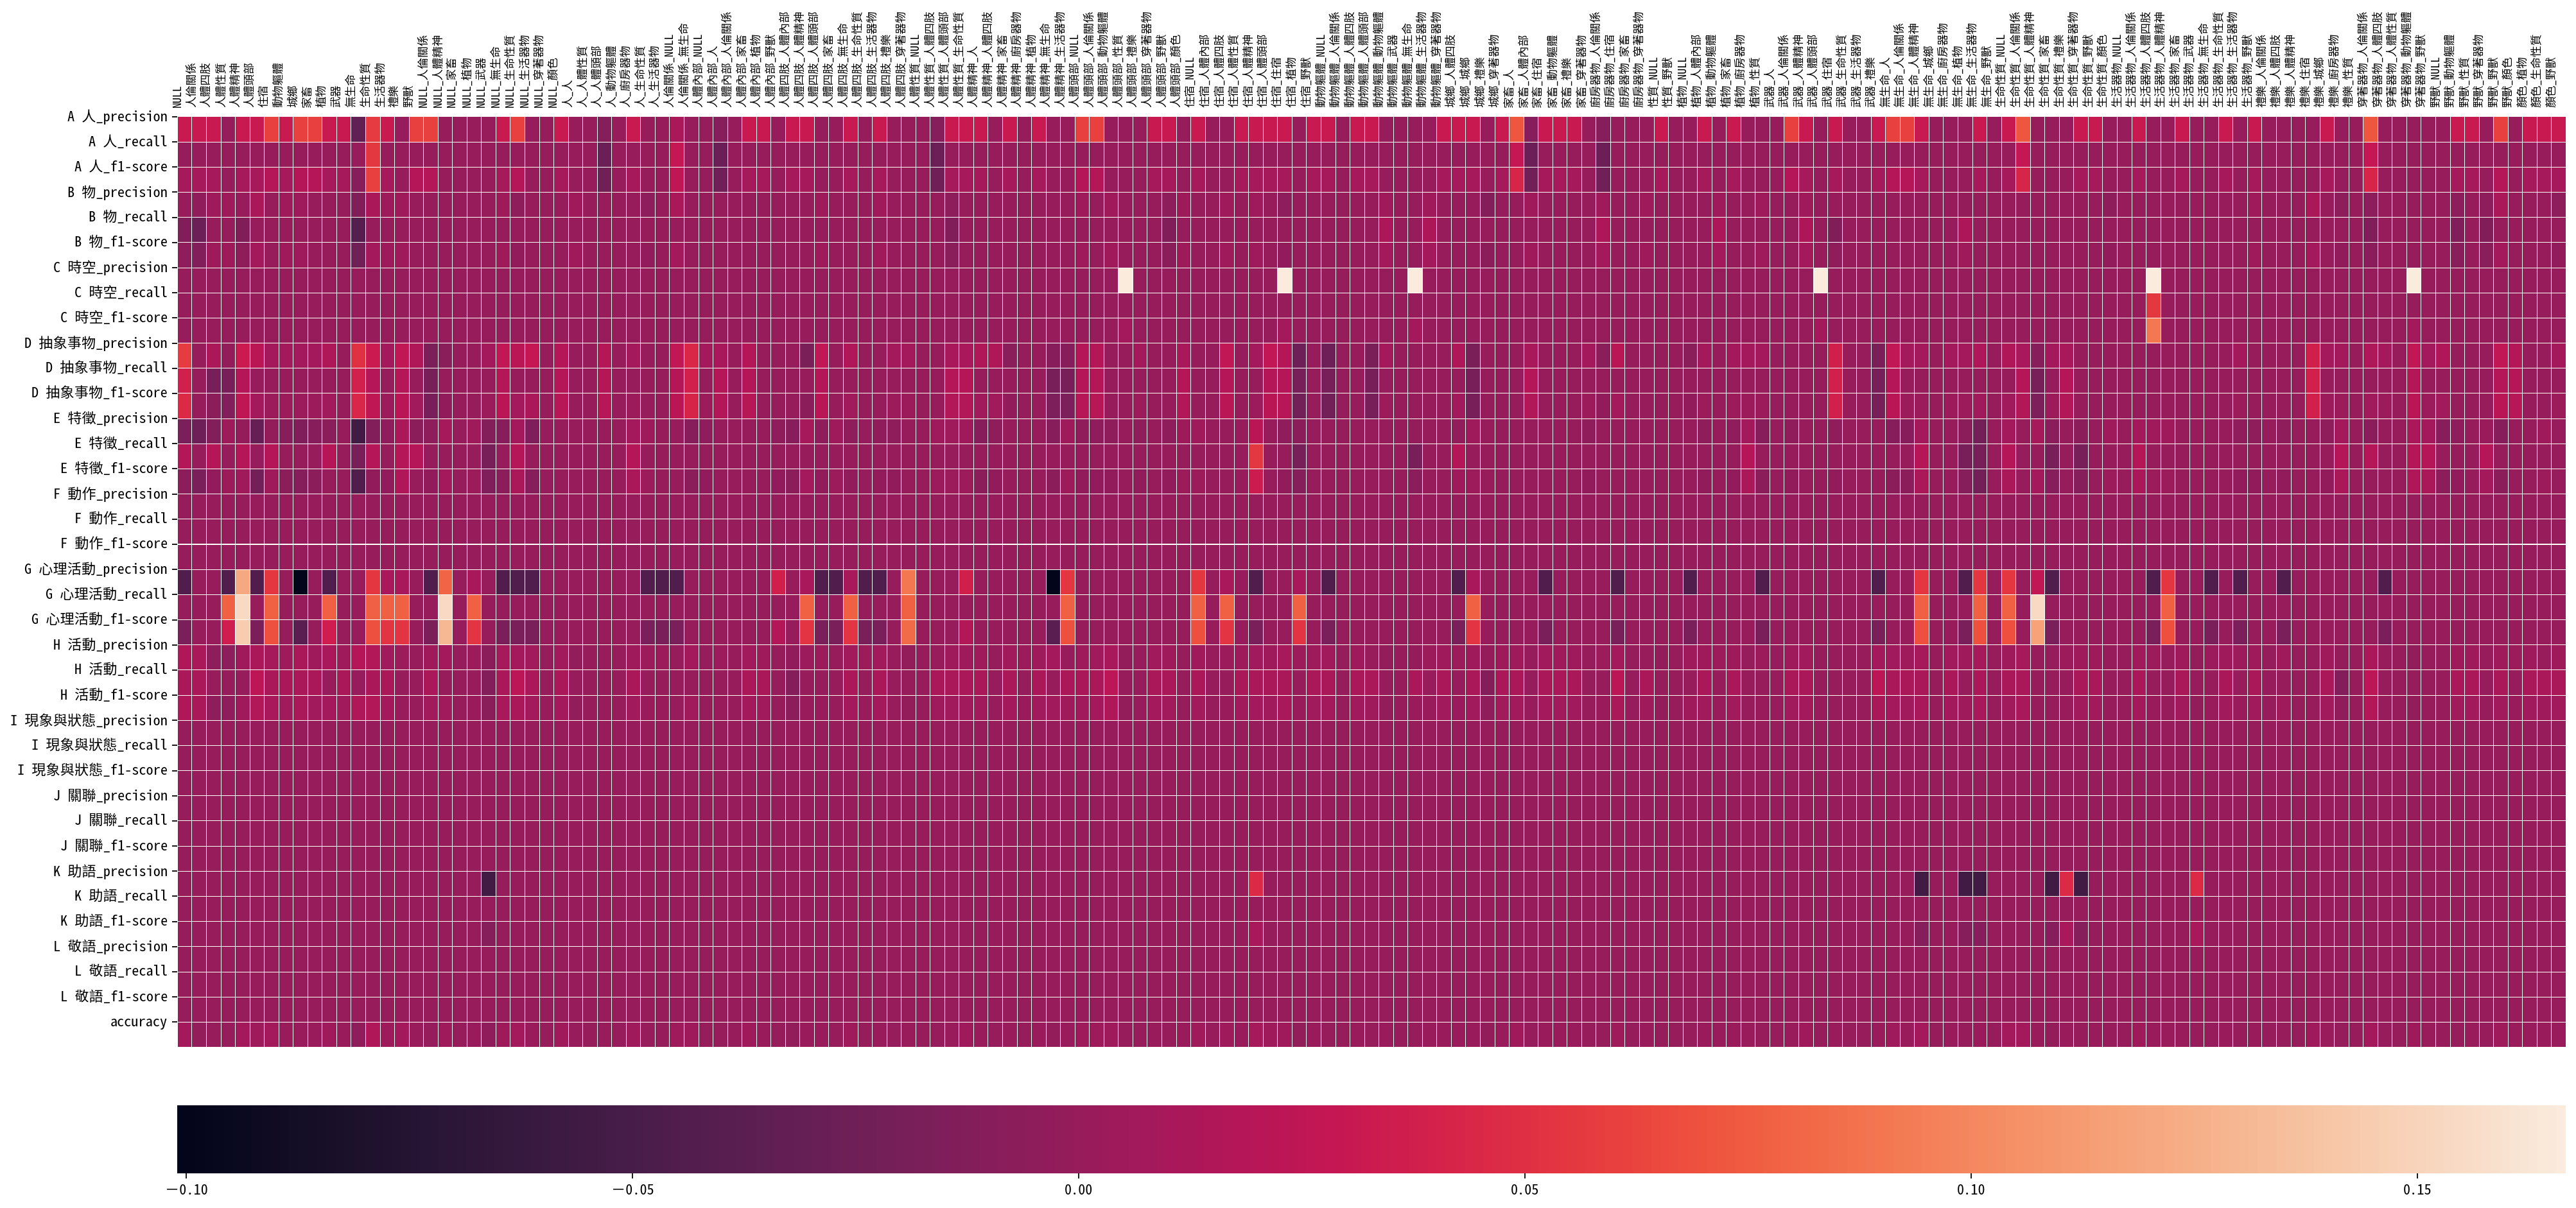

In [161]:
plt.figure(figsize=(30, 15), dpi=160)

dfT = df.T
ax = sns.heatmap(dfT, xticklabels=True, linewidths=0.01, linecolor='white', 
                 cbar_kws=dict(orientation='horizontal', aspect=35, pad=0.05))
ax.set_yticks(range(dfT.shape[0])) # <--- set the ticks first
ax.set_yticklabels(dfT.index, fontsize=10)
ax.set_xticks(range(dfT.shape[1])) # <--- set the ticks first
ax.set_xticklabels(dfT.columns)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, 
                bottom=False, top = False, labeltop=True)
plt.xticks(rotation=90, fontsize=8)
plt.show()

## Heatmap

In [ ]:
# Naive Bayes Posterior: P(X_i|y)
#mat = np.exp(model.feature_log_prob_).T
mat = model.feature_log_prob_.T
mat = pd.DataFrame(mat, index=DTM.features, columns=model.classes_).T
mat

,NULL,人,人倫關係,人體內部,人體四肢,人體性質,人體精神,人體頭部,住宿,動物軀體,城鄉,家畜,廚房器物,性質,植物,武器,無生命,生命性質,生活器物,禮樂,穿著器物,野獸,顏色
A 人,-2.376655,-2.235395,-2.059621,-5.195376,-2.554878,-4.968077,-4.147455,-2.779667,-3.018277,-5.886691,-3.632131,-3.702643,-5.314882,-3.422171,-3.031437,-3.785313,-2.507358,-2.287746,-3.508407,-4.270666,-3.331255,-3.723537,-5.029154
B 物,-2.825967,-3.618996,-3.290451,-4.139421,-2.668580,-5.786956,-4.844553,-3.048141,-3.152344,-4.105586,-3.325587,-3.624696,-4.062039,-3.411256,-2.000196,-3.853920,-1.664090,-3.290896,-3.587636,-4.881086,-2.789183,-2.848255,-3.762662
C 時空,-2.060038,-2.885582,-3.475231,-6.888243,-2.957646,-6.049781,-5.044695,-3.060124,-3.071231,-5.499798,-2.689217,-5.343964,-5.154269,-3.564002,-2.322321,-3.507384,-1.443196,-2.680739,-4.477548,-4.527466,-3.287676,-4.460097,-4.129516
D 抽象事物,-2.137212,-2.920629,-3.527319,-4.349630,-2.495929,-5.350698,-3.081364,-2.945896,-3.262168,-5.107369,-3.031534,-3.844411,-4.752533,-3.604164,-2.500698,-3.349826,-1.966092,-3.015748,-3.578053,-3.602216,-3.070914,-3.861297,-3.833925
E 特徵,-2.202109,-3.062194,-3.674641,-5.105987,-2.464344,-5.862133,-3.247812,-2.861097,-2.984583,-5.185950,-3.429426,-3.805003,-4.471981,-3.573579,-2.587045,-3.557557,-1.739036,-2.757485,-3.804742,-4.205354,-3.206892,-3.516845,-3.622910
F 動作,-2.547787,-2.900187,-4.992522,-7.947467,-1.257359,-4.118118,-4.816979,-2.337786,-3.006686,-4.332575,-4.519806,-3.916261,-4.431405,-3.983130,-3.258398,-2.988487,-2.388835,-2.699204,-3.786233,-4.144894,-3.748497,-3.987854,-6.250042
G 心理活動,-2.012486,-3.160328,-4.160232,-4.848871,-2.631421,-5.330984,-1.711773,-2.633997,-3.538217,-5.043825,-3.984684,-3.727024,-5.912851,-4.347825,-3.552218,-3.551174,-1.604313,-3.073344,-3.853792,-4.398411,-4.487959,-3.841791,-5.008219
H 活動,-2.228500,-2.777878,-3.917055,-5.557865,-1.872390,-4.516529,-4.037551,-2.961262,-3.299044,-4.946404,-3.586314,-3.783447,-3.820124,-3.487162,-2.859562,-3.137638,-2.063424,-2.986547,-3.140643,-3.574716,-3.251185,-3.662254,-4.466976
I 現象與狀態,-2.191941,-3.038063,-3.686735,-5.008289,-2.018702,-6.156962,-3.822508,-2.825491,-3.290864,-5.420264,-3.407158,-3.987643,-4.069795,-3.590796,-2.826944,-3.366620,-1.684610,-2.968462,-3.715589,-3.586233,-3.223765,-3.863165,-4.500293
J 關聯,-2.225884,-2.736101,-3.634023,-5.430471,-1.916247,-5.483044,-3.375546,-2.662666,-3.356664,-4.113481,-3.193194,-3.854332,-4.428500,-3.921830,-2.793016,-3.079801,-1.921470,-2.776853,-4.005211,-4.651118,-3.518181,-4.278557,-4.726978


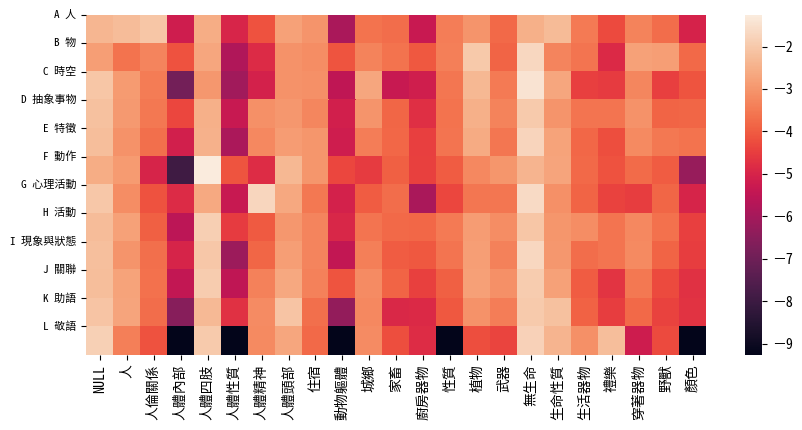

In [ ]:
plt.figure(figsize=(10, 4.5), dpi=100)

ax = sns.heatmap(mat, xticklabels=True)
ax.set_yticks(range(mat.shape[0])) # <--- set the ticks first
ax.set_yticklabels(mat.index, fontsize=8)
plt.show()
# ax = sns.heatmap(tf_idf_mat.toarray(), linewidth=0.5)
# plt.imshow(mat, cmap='hot', interpolation='nearest')

In [ ]:
# Tfidf matrix
DTM = DocumentTermMatrix(Tagger, C, level=1)
mat = pd.DataFrame(DTM.np.T, index=DTM.features, columns=DTM.df_tgt.lev1).T
# mat

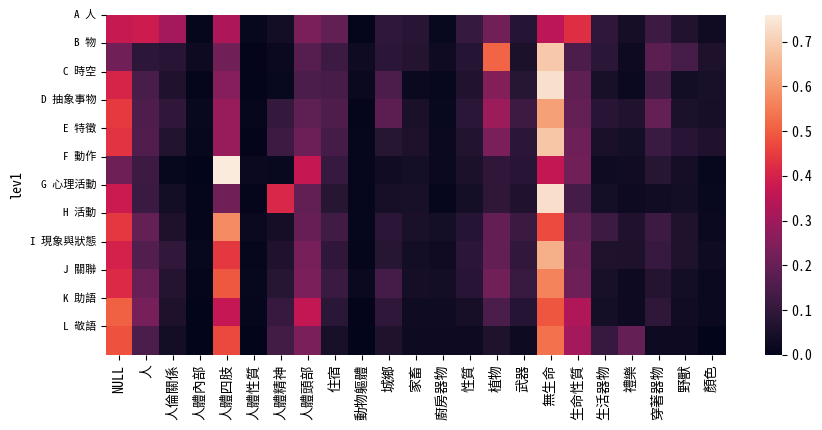

In [ ]:
plt.figure(figsize=(10, 4.5), dpi=100)

ax = sns.heatmap(mat, xticklabels=True)
ax.set_yticks(range(mat.shape[0])) # <--- set the ticks first
ax.set_yticklabels(mat.index, fontsize=8)
plt.show()